In [77]:
import numpy
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import cm
from pylab import *
import os
import pandas as pd
import gc
from scipy.signal import blackman
import csv
from scipy.io import wavfile
import wave
from struct import pack
import plotly,plotly as py
#from numba import vectorize

gc.enable()

data_path = "data/"
date = "20181205"
data_path = "data/"
stereo_path = "stereo/"
vector_path = "vector/"
visual_path = "visual/"

In [131]:
vis_name = "wood"
audio_file = "20181205_185521_191.wav"
sample_rate, signal = scipy.io.wavfile.read(data_path + date + "/18/" +audio_file)

ValueError: x and y must have same first dimension, but have shapes (108416,) and (216832,)

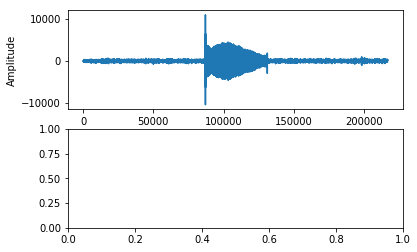

In [132]:
Fs = sample_rate;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

#ff = 5;   # frequency of the signal
#y = np.sin(2*np.pi*ff*t)

n = len(signal) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n/2)] # one side frequency range

Y = np.fft.fft(signal)/n # fft computing and normalization
Y = Y[range(n/2)]

fig, ax = plt.subplots(2, 1)
ax[0].plot(signal)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
ax[1].plot(frq,abs(signal),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')

plot_url = py.plot_mpl(fig, filename='mpl-basic-fft')

In [ ]:
##Run to winden the screen size##

from IPython.core.display import display, HTML 
display(HTML("<style>.container { width:100% !important; }</style>"))

##Convert data to dual channel stereo##

for filename in os.listdir('data/'):
    samplerate, data = wavfile.read('data/' + filename )
    rate = samplerate
    samples = len(data)

    wv = wave.open('stereo/' + filename,'w')
    wv.setparams((2, 2, rate, 0, 'NONE', 'Uncompressed'))
    
    print filename 
    
    wvData = ""
    for i in range(0, samples):
        wvData += pack('h', data[i]) 
        
    wv.writeframes(wvData)
    wv.close()
    gc.collect()
    
print 'All wav files have been converted to dual channel stereo'

In [133]:
#date = "20181205"


for filename in os.listdir(data_path):
    
    filename = audio_file

    ##Reading the wav file##
    sample_rate, signal = scipy.io.wavfile.read(data_path + date + "/18/" +filename)
    #signal = signal[:,1]
    #data_left = signal[:, 0]
    #data_right = signal[:, 1]
    signal = signal[int(1.9*sample_rate):int(3.1*sample_rate)]
    #signal = signal[int(12.55*sample_rate):int(12.7*sample_rate)] #keep the first 3.5 seconds
    #signal = signal[int(0*sample_rate):int(60*sample_rate)]


    ##Pre-emphasis##
    pre_emphasis = 0.97
    emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])



    ##Framing##
    frame_size = 0.01#0.01#0.025#
    frame_stride = 0.00155#0.00144#overlapping=frame_size-frame_stride
    #overlapping=float(frame_size-frame_stride)/frame_size
    frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate
    signal_length = len(emphasized_signal)
    frame_length = int(round(frame_length))
    frame_step = int(round(frame_step))
    num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))
    print "num_frames=",num_frames
    pad_signal_length = num_frames * frame_step + frame_length
    z = numpy.zeros((pad_signal_length - signal_length))
    pad_signal = numpy.append(emphasized_signal, z)
    indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(numpy.int32, copy=False)]



    ##Window##
    #frames *= numpy.hamming(frame_length)
    frames *= blackman(frame_length)



    ##Fourier-transform and power spectrum##
    NFFT = 1024
    mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT)) #magnitude of the FFT
    pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2)) #power spectrum
    pow_frames_new = pow_frames[:,400:500]
    print "pow_frames=",len(pow_frames)
    print "pow_frames=",pow_frames.shape
    print "pow_frames=",type(pow_frames)



    ##Filter banks##
    nfilt = 40
    low_freq_mel = (2595 * numpy.log10(1 + (18000) / 700))
    high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700)) #convert Hz to Mel
    
    mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2) #equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1)) #converts Mel to Hz
    bin = numpy.floor((NFFT +1) * hz_points / sample_rate)
    print "hz_points=",hz_points
    fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 +1))))
    #fbank = numpy.zeros((nfilt,100))
    print "fbank=",fbank.shape
    for m in range(1, nfilt + 1):
        f_m_minus = int(bin[m - 1]) #left
        f_m = int(bin[m]) #center
        f_m_plus = int(bin[m + 1]) #right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
    print "fbank=",fbank.shape
    filter_banks = numpy.dot(pow_frames, fbank.T)
    #fbank_new = fbank[:,0:100]
    #filter_banks = numpy.dot(pow_frames_new, fbank_new.T)
    filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks) #numerical stability
    filter_banks = 20 * numpy.log10(filter_banks) #dB



    ##Mel-Frequency Cepstral Coefficients (MFCCs)##
    num_ceps = 12
    mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] #keep 2-13
    cep_lifter = 22
    (nframes, ncoeff) = mfcc.shape
    n = numpy.arange(ncoeff)
    lift = 1 + (cep_lifter / 2) * numpy.sin(numpy.pi * n / cep_lifter)
    mfcc *= lift



    ##Mean normalization##
    filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
    mfcc -= (numpy.mean(mfcc, axis=0) + 1e-8)
    pow_frames_new -= (numpy.mean(pow_frames_new, axis=0) * 1e-8)
    #filter_banks -= (numpy.mean(filter_banks, axis=0) + 1e-8)
    print "length mfcc",len(mfcc)



    ##Data frames##
    string=[["" for x4 in range(1)] for y4 in range(239)]
    string2=[["" for x3 in range(1)] for y3 in range(num_frames+3)]
    string3=[]
    string[0][0] += os.path.splitext(filename)[0]
    #print string[0][0]
    string[0][0] = (string[0][0])[0:4]+"/"+(string[0][0])[4:6]+"/"+(string[0][0])[6:8]+" "+(string[0][0])[9:11]+":"+(string[0][0])[11:13]+":"+(string[0][0])[13:15]+"."+(string[0][0])[16:19]
    string_date = str(string[0][0])
    #print string_date
    new_date=datetime.datetime.strptime(string_date, "%Y/%m/%d %H:%M:%S.%f")

    for i2 in range(0,num_frames+3):
        #new_date2 = new_date+datetime.timedelta(milliseconds=frame_size*0.4*1000*i2) #(22050/samplerate)*i2)
        #new_date2 = new_date+datetime.timedelta(milliseconds=(frame_stride*1000*i2)) #(22050/samplerate)*i2)
        new_date2 = new_date+datetime.timedelta(milliseconds=((60.0/38909.0)*1000*i2))
        #print new_date2
        string2[i2][0] = new_date2.strftime("%Y/%m/%d %H:%M:%S.%f")[:-3]  
        #string[i2][0].strftime('%Y/%m%d %H:%M:%S.%f')
        string3.append((string2[i2][0])[0:4]+"/"+(string2[i2][0])[5:7]+"/"+(string2[i2][0])[8:10]+" "+(string2[i2][0])[11:13]+":"+(string2[i2][0])[14:16]+":"+(string2[i2][0])[17:19]+"."+(string2[i2][0])[20:23])
        if i2 == 0:
            filename1 = ((string2[i2][0])[0:4]+(string2[i2][0])[5:7]+(string2[i2][0])[8:10]+(string2[i2][0])[11:13]+(string2[i2][0])[14:16]+(string2[i2][0])[17:19]+(string2[i2][0])[20:23])    
        filename2 = ((string2[i2][0])[0:4]+(string2[i2][0])[5:7]+(string2[i2][0])[8:10]+(string2[i2][0])[11:13]+(string2[i2][0])[14:16]+(string2[i2][0])[17:19]+(string2[i2][0])[20:23])

    #print "string2 length= ",len(string2)
    #print string2
    #np.savetxt(fname="time", X=string2, delimiter=',')
    np.asarray(string3)
    #np.vstack((string,b))
    #print "string3_type=", type(string3)
    
    
    ##save date_time index into a csv file##
    with open(filename[:-4] + ".csv", 'wb') as index_csv:
        wr = csv.writer(index_csv, quoting=csv.QUOTE_ALL)
        wr.writerow(string3)

    
    ##Save text data##
    #np.savetxt(fname=filename1 + "-" + filename2, X=np.concatenate((string3,mfcc),axis = 0), delimiter=',')
    df = pd.DataFrame(mfcc)
    
    ##Repeat last data frame 3 times to match the no of frames##
    for i in range(38905,38906):
        df = pd.concat([df]+[df.iloc[i:i+1,]]*3)
    #df.index=string3
    #print df
    #display(df.head)
    #df.to_csv(vector_path + filename1 + "-" + filename2, header=None)
    #np.savetxt(fname=filename1 + "-" + filename2, X=pow_frames, delimiter=',')
    gc.collect()
    
    
    
    print filename
    ##Plotting##
    #cmap=plt.get_cmap('jet')
    #plt.figure(figsize = (20,5))
    #plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, interpolation='nearest', vmin=-250, vmax=250, origin='lower', extent=[0,60,0,12], aspect='auto')
    #plt.imshow(numpy.flipud(pow_frames.T), cmap=cm.magma, interpolation='nearest', vmin=0, vmax=100000, origin='lower', extent=[0,2,0,12], aspect='auto')

    #plt.colorbar()
    #plt.tight_layout()
    #plt.savefig(visual_path + filename1 + "-" + filename2 + ".png")
    #plt.savefig("no_mean" + ".png")
    #plt.show()
    
    break

    #plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, aspect='auto', extent=[0,50,0,13]) #second var is the time you want to keep from the recording

print "All done!"

num_frames= 772
pow_frames= 772
pow_frames= (772, 513)
pow_frames= <type 'numpy.ndarray'>
hz_points= [17500.         17592.40541078 17685.27998419 17778.62610228
 17872.44615917 17966.74256118 18061.5177268  18156.77408681
 18252.51408436 18348.74017498 18445.45482667 18542.66051995
 18640.35974796 18738.55501648 18837.24884402 18936.44376187
 19036.14231418 19136.34705801 19237.0605634  19338.28541346
 19440.02420439 19542.27954558 19645.05405967 19748.35038262
 19852.17116376 19956.51906589 20061.39676532 20166.80695193
 20272.75232929 20379.23561468 20486.25953918 20593.82684773
 20701.9402992  20810.6026665  20919.81673658 21029.58531056
 21139.91120378 21250.79724588 21362.24628084 21474.26116712
 21586.84477766 21700.        ]
fbank= (40, 513)
fbank= (40, 513)
length mfcc 772
20181205_185521_191.wav
All done!


(40, 513)


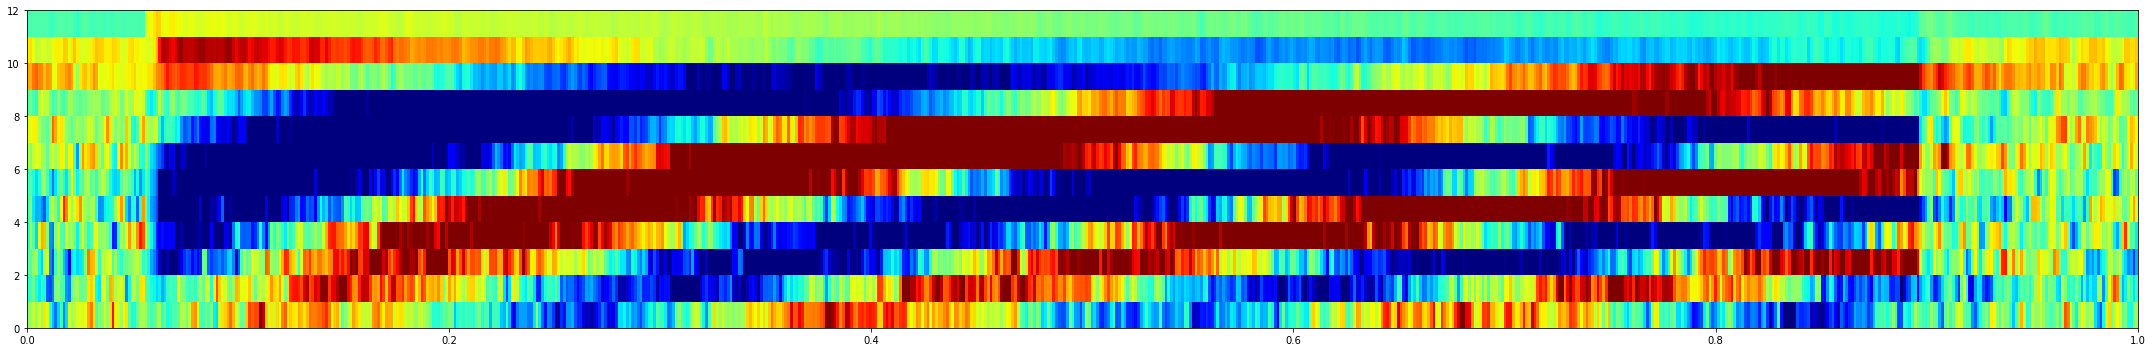

In [134]:
cmap=plt.get_cmap('jet')
plt.figure(figsize = (30,5))
plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, interpolation='nearest', vmin=-500, vmax=500, origin='lower', extent=[0,len(signal)/sample_rate,0,12], aspect='auto')
#plt.imshow(numpy.flipud(pow_frames_new.T), cmap=cm.viridis, interpolation='nearest', vmin=0, vmax=100000, origin='lower', extent=[0,2,0,513], aspect='auto')
#plt.imshow(numpy.flipud(fbank.T), cmap=cm.magma, interpolation='nearest', vmin=-30, vmax=30, origin='lower', extent=[0,2,0,513], aspect='a#fbankplt.imshow(numpy.flipud(fbank.T), cmap=cm.magma, interpolation='nearest', vmin=-30, vmax=30, origin='lower', extent=[0,2,0,513], aspect='auto')

print fbank.shape

#plt.colorbar()
plt.tight_layout()
    #plt.savefig(visual_path + filename1 + "-" + filename2 + ".png")
plt.savefig(vis_name + ".png")
plt.show()

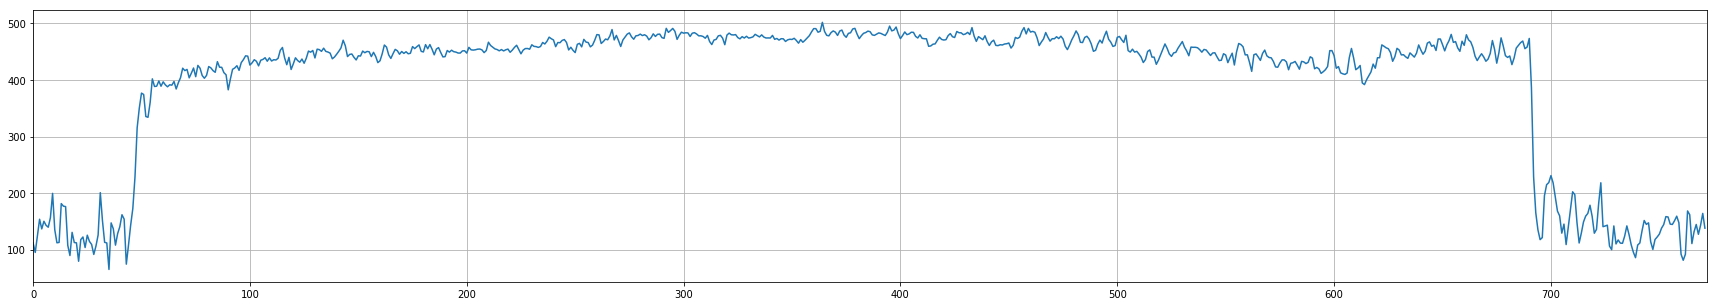

In [135]:
df_mfcc = pd.DataFrame(mfcc.T)
df_mfcc.std(axis=0).plot(figsize = (30,5),grid=1,xlim=[0,len(df_mfcc.T)])
plt.savefig(vis_name + "std" + ".png")

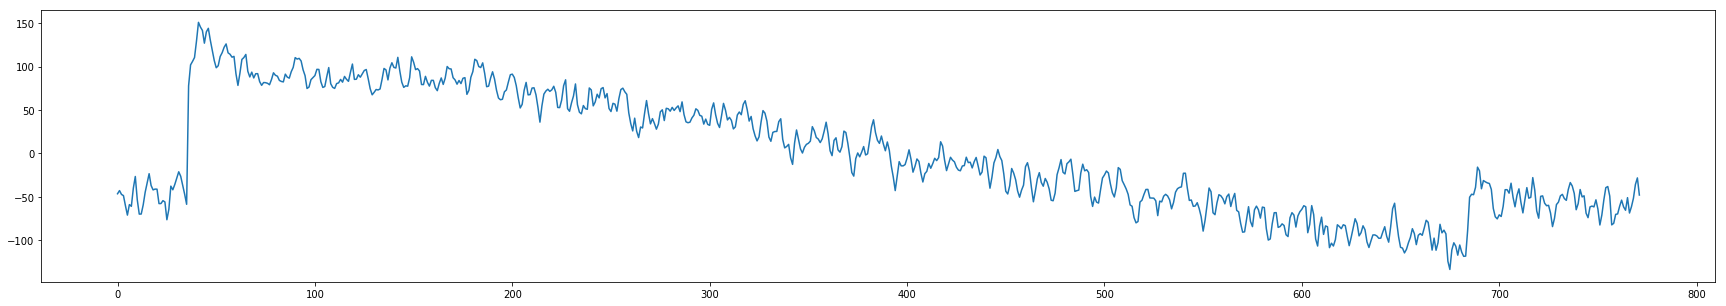

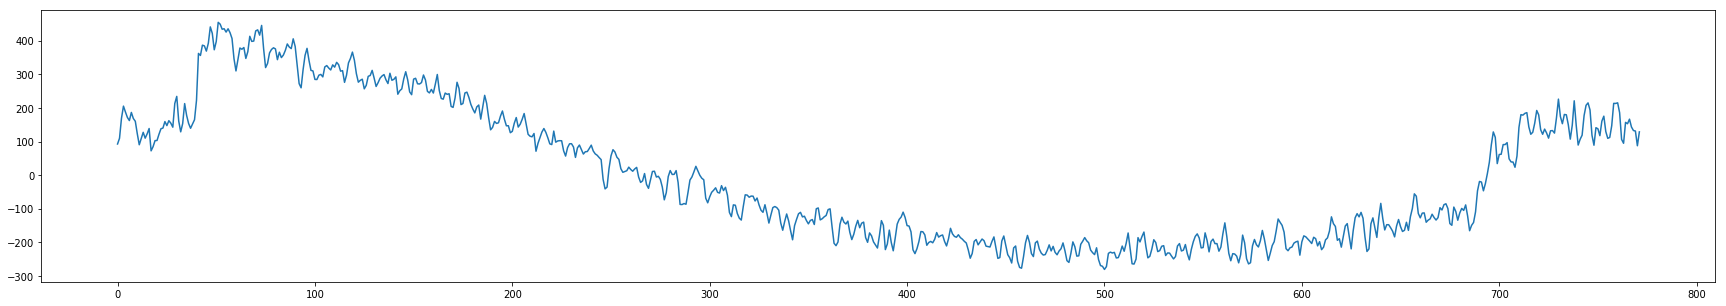

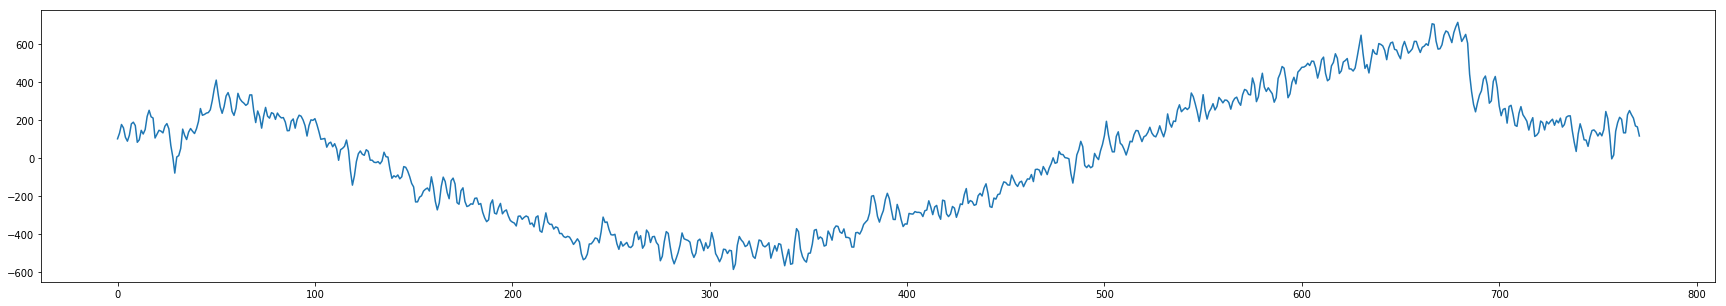

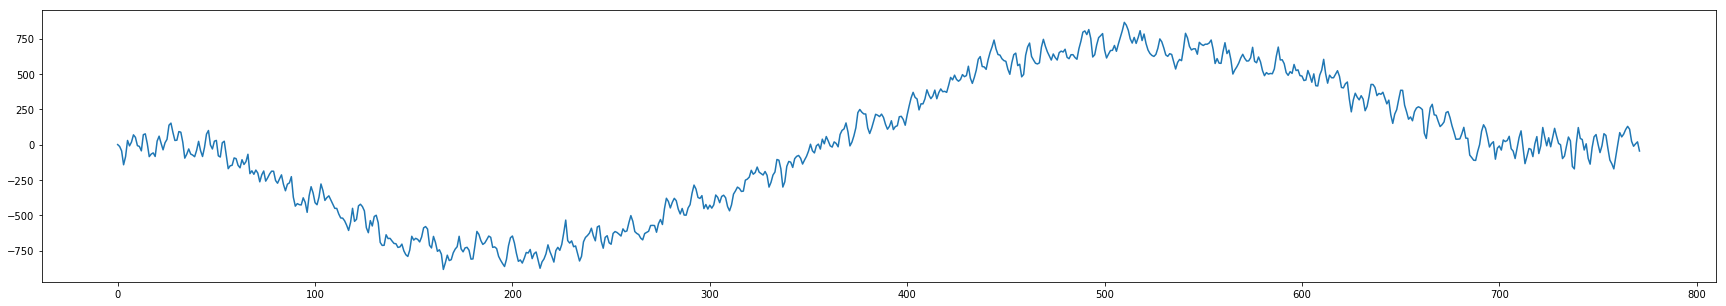

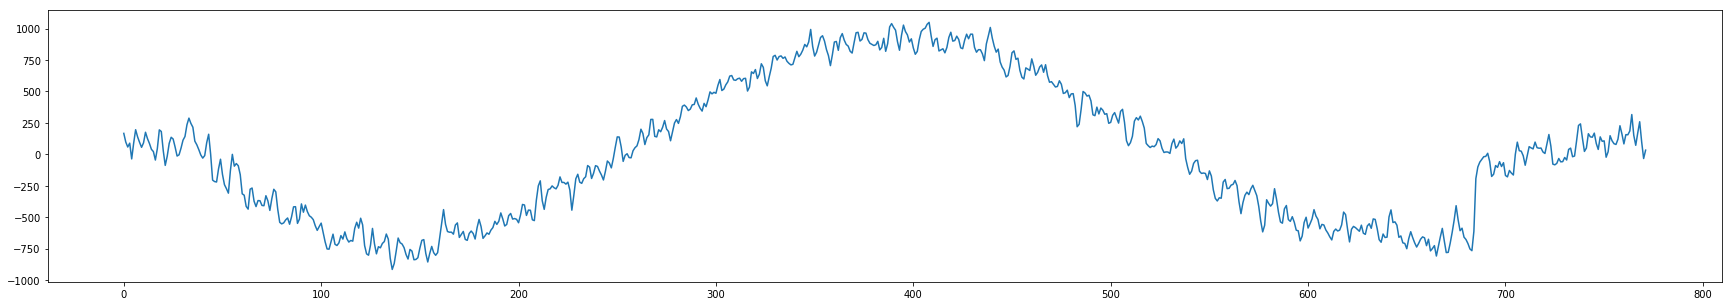

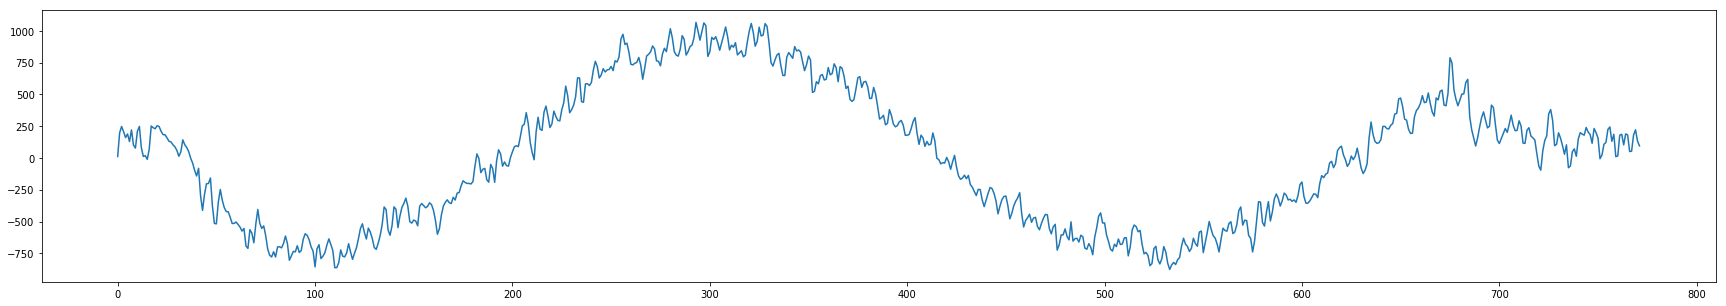

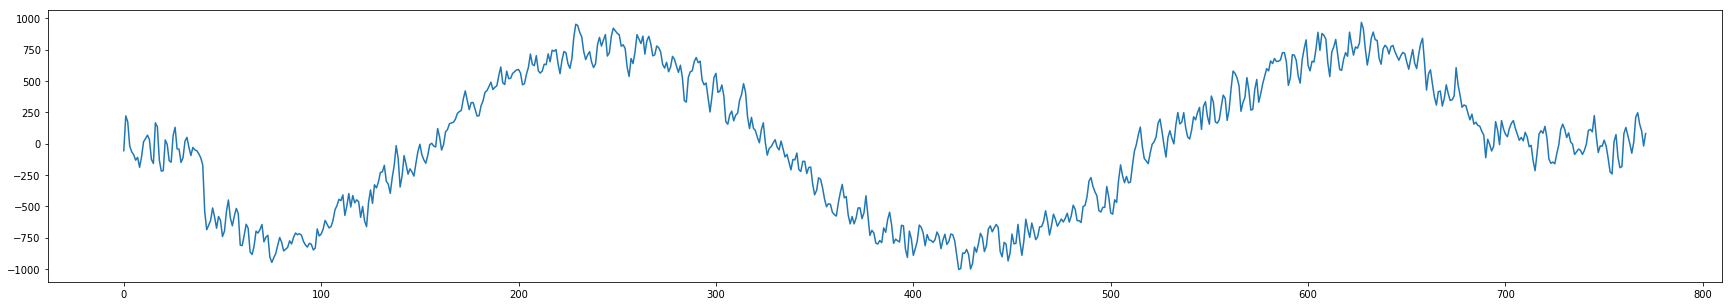

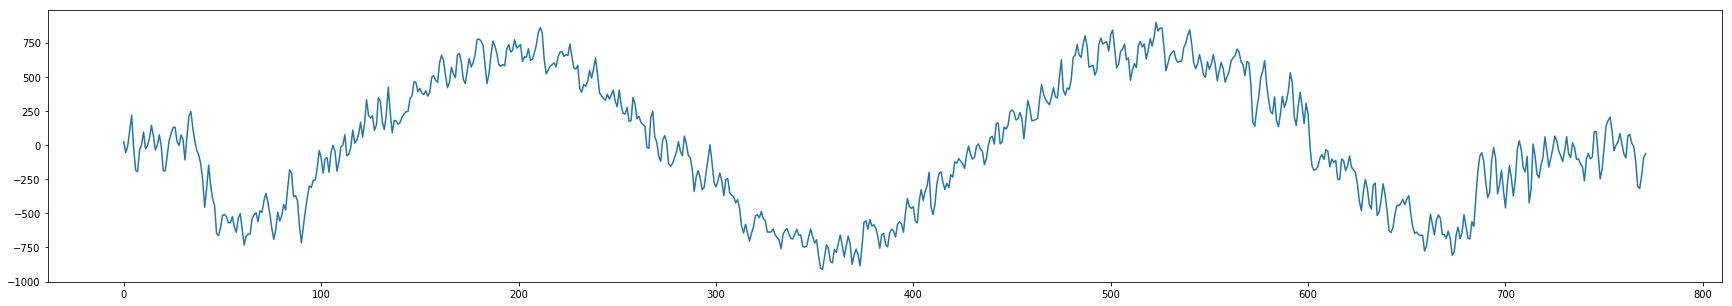

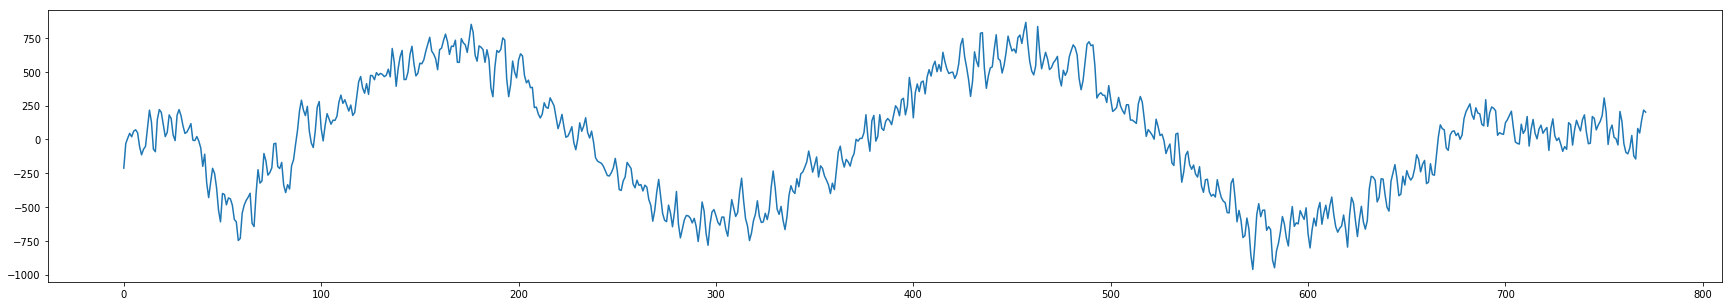

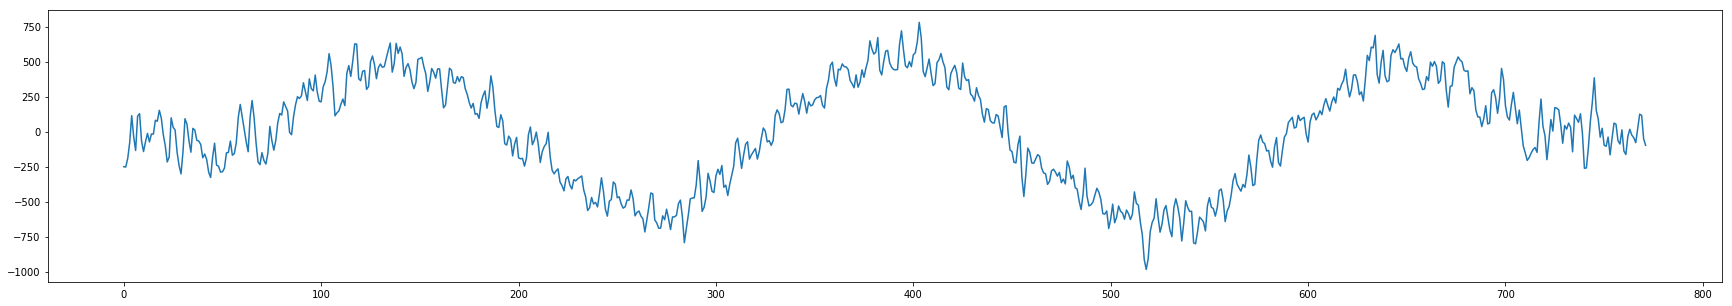

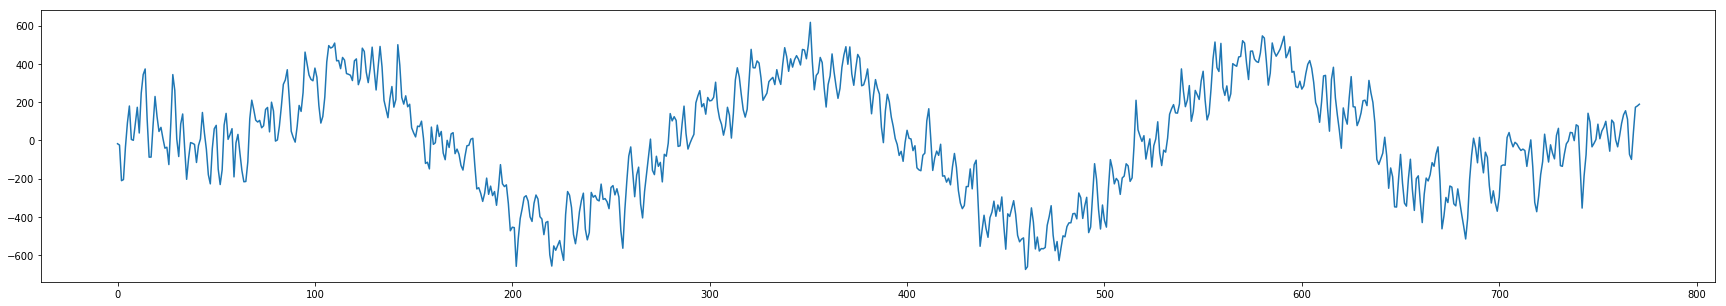

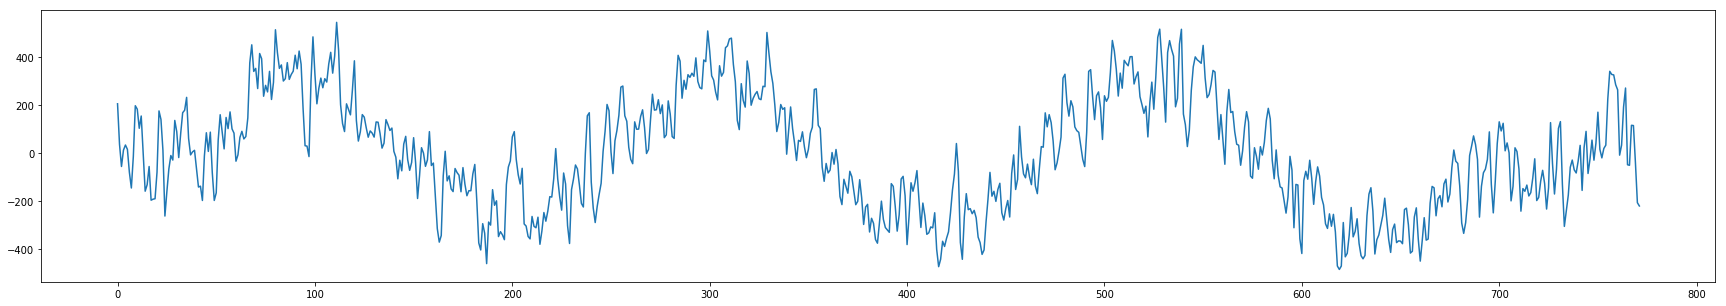

In [72]:
for x in range(0,len(mfcc[1])):
    plt.figure(figsize = (30,5))
    plt.plot(mfcc.T[x])
    plt.savefig("coef" + str(x) + ".png")
    plt.show()

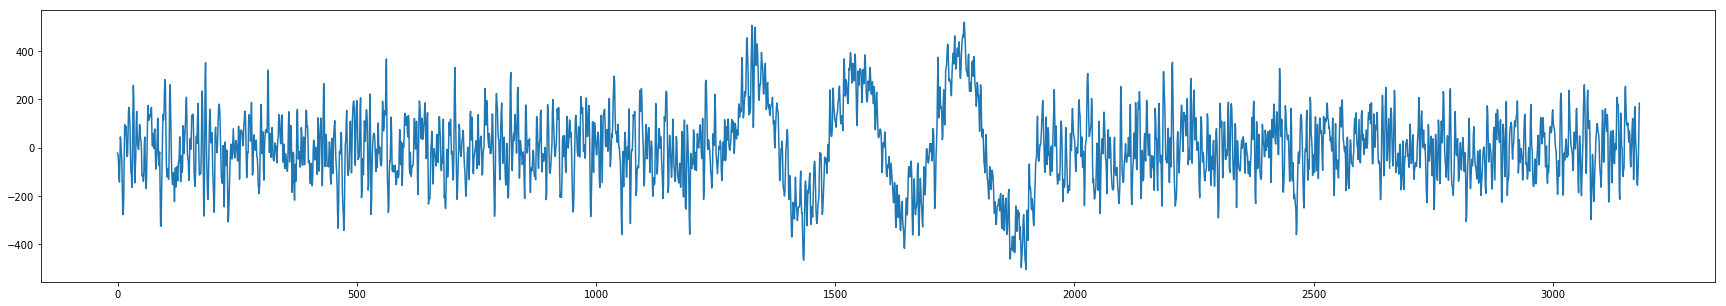

In [26]:
denoised_mfcc = []
for y in range(1,len(mfcc.T[1])):
    denoised_mfcc.append((mfcc.T[11,y] + mfcc.T[11,y-1])/2)
    
plt.figure(figsize = (30,5))
plt.plot(denoised_mfcc)
#plt.savefig("coef" + str(x) + ".png")
plt.show()

In [22]:
denoised_mfcc

19.28948249014639

In [12]:
with open('test_list.csv','rb') as index_csv:
    index_string = csv.reader(index_csv)
    my_list = list(index_string)
    
print len(my_list)
print type(my_list)
#print my_list

df.index = my_list

print df

1
<type 'list'>
                                 0           1           2           3   \
2017/12/13 00:33:01.931  120.350361 -137.870955  307.549992 -109.890683   
2017/12/13 00:33:01.932  -14.097990 -216.180623  177.103509 -110.729552   
2017/12/13 00:33:01.934  -25.136457 -231.151246  133.284628 -149.063822   
2017/12/13 00:33:01.935  -10.233704 -196.982314  100.786098 -244.824880   
2017/12/13 00:33:01.937    2.001506 -153.996109   89.416127 -282.411140   
2017/12/13 00:33:01.938   11.383966 -138.423697   42.879333 -305.658152   
2017/12/13 00:33:01.940   12.104051 -147.686842   16.879440 -286.231973   
2017/12/13 00:33:01.941    7.105869 -162.006390   30.882476 -238.918226   
2017/12/13 00:33:01.943   14.234742 -125.359403  130.489077 -169.283198   
2017/12/13 00:33:01.944   27.594830  -87.895828  186.582941 -193.367623   
2017/12/13 00:33:01.946   35.293808 -102.433392  163.684305 -178.513849   
2017/12/13 00:33:01.947   38.595477 -107.158740   96.468926 -233.970817   
2017/12/1

(253, 513)


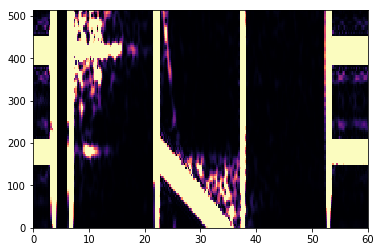

In [6]:
print pow_frames.shape
plt.imshow(numpy.flipud(pow_frames_new.T), cmap=cm.magma, interpolation='nearest', vmin=0, vmax=100000, origin='lower', extent=[0,60,0,513], aspect='auto')
plt.show()

In [9]:
new_mfcc = np.ndarray(shape = (12,len(mfcc)))
for i in range(3,len(mfcc)):
    df.iloc[i - 3:i].mean(axis = 0).T.to_csv('test.csv', mode = 'a', header = False)
    i = i + 3
    #new_mfcc

print new_mfcc.shape

KeyboardInterrupt: 

In [ ]:
cmap=plt.get_cmap('jet')
plt.figure(figsize = (20,5))
plt.imshow(numpy.flipud(mfcc.T), cmap=cm.jet, interpolation='nearest', vmin=-250, vmax=250, origin='lower', extent=[0,2,0,12], aspect='auto')
#plt.imshow(numpy.flipud(pow_frames.T), cmap=cm.magma, interpolation='nearest', vmin=-250, vmax=250, origin='lower', extent=[0,2,0,12], aspect='auto')

plt.colorbar()
plt.tight_layout()
#plt.savefig(visual_path + filename1 + "-" + filename2 + ".png")
plt.savefig("no_mean" + ".png")
plt.show()

In [13]:
df

,0,1,2,3,4,5,6,7,8,9,10,11
0,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08
1,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08
2,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08
3,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08
4,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08
5,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08
6,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08
7,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08
8,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08
9,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08,-1.000000e-08
